## Industrial green fuel demand
1. Loading of all packages and functions
2. Per subsector (Steel, Basic Chemicals, NMM)
3. 

### Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import ogr

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

### Input Variables

In [3]:
os.chdir(r"c:\\Users\\flv.eco\\OneDrive - CBS - Copenhagen Business School\\Documents\\01_PtX_Markets\\")

In [4]:
jrc_region = 'SK'
#['EU27', 'AT', 'BE', 'BG', 'CY', 
# 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 
# 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 
# 'PT', 'RO', 'SE', 'SI', 'SK']

gdp_region = 'Slovakia'
#['European Union - 27 countries (from 2020)', 'Austria','Belgium', 'Bulgaria', 'Cyprus', 
# 'Czechia','Germany', 'Denmark', 'Estonia', 'Greece', 'Spain','Finland', 'France', 'Croatia', 
# 'Hungary', 'Ireland', 'Italy', 'Lithuania','Luxembourg', 'Latvia', 'Malta','Netherlands', 'Poland',
# 'Portugal', 'Romania', 'Sweden',  'Slovenia', 'Slovakia']

In [5]:
targets_steel_bf = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}


### Functions

In [30]:

def linear_regression_single_sector(demand_df, sector_name, historic_gdp, projected_gdp, gdp, region, unit, plot=False, save=False):
    """
    Perform linear regression on a single-sector demand dataset and optionally plot/save results.

    Parameters:
    - demand_df: DataFrame with Year as index and one column with demand data.
    - sector_name: Name of the sector (string) to label outputs.
    - historic_gdp: DataFrame of historical GDP data (matching time index).
    - projected_gdp: DataFrame of future GDP data (matching time index).
    - gdp: Full GDP data for plotting (includes past + future).
    - region: Name of the region (string) for GDP plotting.
    - unit: String unit label for demand.
    - plot: Boolean to show a plot of historical and predicted demand.
    - save: Boolean to save the results as an Excel file.

    Returns:
    - results: DataFrame with predicted future demand indexed by year.
    """

    # Merge demand and GDP data for modeling
    historical_data = demand_df.join(historic_gdp)

    # Standardize historical GDP for PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(historic_gdp)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(data_scaled)

    # Add principal component to dataset
    historical_data['PC1'] = principal_components

    # Define feature matrix X and target y
    y = historical_data[demand_df.columns[0]]  # demand
    X = historical_data[['PC1']]               # first principal component of GDP

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Transform future GDP data using the same scaler and PCA
    future_data_scaled = scaler.transform(projected_gdp)
    future_pc1 = pca.transform(future_data_scaled)
    future_pc1_df = pd.DataFrame(future_pc1, index=projected_gdp.index, columns=['PC1'])

    # Predict future demand
    y_future = model.predict(future_pc1_df)
    y_future = np.maximum(y_future, 0)  # Ensure demand is non-negative

    # Assemble prediction DataFrame
    results = pd.DataFrame({'Predicted Demand': y_future}, index=projected_gdp.index)

    # Optional plot
    if plot:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot historical and predicted demand
        ax1.plot(demand_df.index, y, label='Historical Demand', color='darkblue')
        ax1.plot(results.index, results['Predicted Demand'], label='Projected Demand (2022–2050)', linestyle='--', color='blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel(f'Demand in {unit}')
        ax1.legend(loc='upper left')

        # Plot GDP on a secondary axis (in millions)
        ax2 = ax1.twinx()
        ax2.plot(gdp.index, gdp[region] / 1_000_000, label='GDP', color='green')
        ax2.plot(projected_gdp.index, projected_gdp[region] / 1_000_000, label='Projected GDP', linestyle='--', color='lightgreen')
        ax2.set_ylabel('GDP (in million EUR)')
        ax2.legend(loc='upper right')

        plt.title(f'Demand Projection for {sector_name} in {region}')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Optional save
    if save:
        file_path = f"Scripts/Results/{datetime.datetime.today():%Y_%m_%d}_{sector_name.replace(' ', '_')}_{region}.xlsx"
        results.to_excel(file_path)

    return results


In [32]:
def apply_linear_target(demand_df, column_name_all, column_name_after, targets):
    """
    Linearly interpolate a percentage share over time and apply to demand data.

    Parameters:
    - demand_df: pd.DataFrame with datetime-like index, production volume per year.
    - column_name_all: str, name of the column with total demand.
    - column_name_after: str, name of the new column for adjusted demand.
    - targets: dict, keys are years (as int) and values are target percentages (as float, e.g., 0.1 for 10%).

    Returns:
    - pd.DataFrame with an additional column for adjusted demand based on interpolated shares.
    """

    # Create a Series for the target percentages
    target_years = pd.Series(targets)
    target_years.index = pd.to_datetime(target_years.index, format='%Y')
    target_years = target_years.sort_index()

    # Create a full year range between start and end
    full_index = demand_df.index

    # Interpolate linearly and fill missing values
    interpolated_share = (
        target_years.reindex(full_index)
        .interpolate(method='time')
        .ffill()
        .fillna(0)
    )

    # Apply the interpolated share to the demand
    demand_df[column_name_after] = demand_df[column_name_all] * interpolated_share

    return demand_df


### Load gdp data projections 

In [8]:
file_name = 'JRC_DATA\JRC-IDEES-2021\\' +jrc_region+ '\JRC-IDEES-2021_Industry_'+jrc_region+'.xlsx'


gdp = pd.read_excel("Scripts\Projected_GDP.xlsx", index_col="Year")
gdp.index= pd.to_datetime(gdp.index, format='%Y')
gdp = gdp[[gdp_region]]
historic_gdp = gdp[gdp.index < '2022-01-01']
projected_gdp = gdp[gdp.index > '2021-01-01']


## Demand Projections

#### Melting and Casting of Iron and Steel, Aluminium Production, Non-Ferrous Metals

According to UBA (Umweltbundesamt), these processes are already at **TRL 9** for electrification.  
As a result, **full electrification is assumed** for melting, casting, and related metallurgical operations.

---

#### Steam Production

Electrification of steam generation is technically mature, with **electrical alternatives at TRL 9**.  
Available technologies include:
- **Electrode boilers**
- **High-temperature heat pumps**
- **Electric resistance heating systems**

These systems are considered viable substitutes for fossil-based steam generation in industrial contexts.

---

#### Metal Processing in Machinery and Transport Equipment

This category is **already predominantly electrified**.  
Remaining fossil-based energy use is minimal and could be substituted with **green fuels** if necessary,  
though the overall impact is considered **relatively small** in the broader decarbonization strategy.


### Steel Sector: Demand Estimation and Hydrogen Integration

This sector models hydrogen demand in the steel industry by differentiating between the two primary production routes: **Electric Arc Furnace (EAF)** and **Blast Furnace–Basic Oxygen Furnace (BF-BOF)**, with a focus on the transition to **Direct Reduced Iron (DRI)** using hydrogen.

---

####  Calculation Steps and Modeling Logic

1. **Estimate steel production activity** until 2050, with separate projections for EAF and BF/DRI routes.
2. **Quantify hydrogen demand** for the DRI-BF route based on specific energy consumption (SEC) and process assumptions from Neuwirth et al.
3. **Simulate hydrogen adoption** based on a stepwise integration aligned with European decarbonization targets.

---

#### Input Assumptions

##### Electric Arc Furnace (EAF)

- Assumes **no hydrogen demand**.
- Production relies entirely on **electricity and steel scrap recycling**.
- Referenced from **Neuwirth (2022), Appendix B**, confirming no hydrogen use in EAF operation.

##### Integrated Steel Production (BF/DRI Route)

- Modeled as transitioning from conventional BF-BOF to **hydrogen-based DRI**.
- Specific Energy Consumption (SEC) for hydrogen-based DRI route:
  - **1.89 MWh per tonne of steel**
  - *Source: Neuwirth (2022)*

- According to **Müller (2021)**:
  > The transition to carbon-free CDRI increases electricity demand from  
  > ε<sub>el,scrap</sub> = **1.76 GJ/t<sub>steel</sub>** (scrap processing)  
  > to ε<sub>el,DRI</sub> = **2.26 GJ/t<sub>steel</sub>** (DRI processing)

- Additional analysis may be required to refine assumptions around **changing energy inputs** during process conversion.

---


In [14]:
# Read in JRC data for the Iron and Steel sector
steel = pd.read_excel(file_name, sheet_name="ISI")
steel_column_name = jrc_region + ": Iron and steel"

# Ensure all column names are strings
steel.columns = steel.columns.astype(str)

# Drop unnamed columns (often index artifacts), create a copy to avoid SettingWithCopyWarning
steel_cleaned = steel.loc[:, ~steel.columns.str.contains('^Unnamed:')].copy()

# Drop rows with any missing values and reset the index
steel_cleaned.dropna(how='any', inplace=True)
steel_cleaned.reset_index(drop=True, inplace=True)

Project production of EAF and BF steel production route

In [ ]:
# Extract the third row (index 2) of the cleaned data as a new DataFrame
steel_bf = pd.DataFrame(steel_cleaned.iloc[2])

# Set the column names to the values in the row (assumes the row contains headers)
steel_bf.columns = steel_bf.iloc[0]

# Drop rows with labels 'Iron and steel' and 'Code', which are metadata and not actual years
steel_bf.drop([steel_column_name, 'Code'], axis=0, inplace=True)

# Set the index name to 'Year' and convert the index to datetime format
steel_bf.index.name = 'Year'
steel_bf.index = pd.to_datetime(steel_bf.index, format='%Y', errors='coerce')

In [22]:
# Extract the fourth row (index 3) of the cleaned data as a new DataFrame
steel_eaf = pd.DataFrame(steel_cleaned.iloc[3])

# Set column names based on the first row (assumes it contains headers or units)
steel_eaf.columns = steel_eaf.iloc[0]

# Drop metadata rows that are not actual years (like the sector name or 'Code')
steel_eaf.drop([steel_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime for consistency
steel_eaf.index.name = 'Year'
steel_eaf.index = pd.to_datetime(steel_eaf.index, format='%Y', errors='coerce')


####  Calculation Steps and Modeling Logic

1. **Estimate steel production activity until 2050, with separate projections for EAF and BF/DRI routes.**


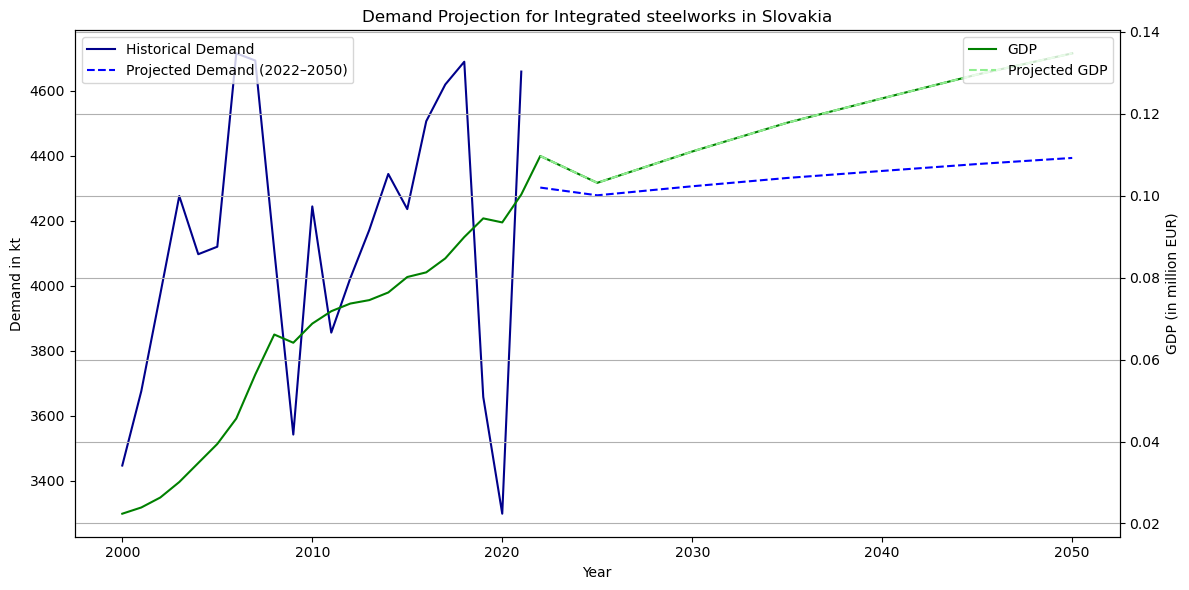

In [48]:
# Run linear regression for the Blast Furnace route in the steel sector
steel_bf_projection = linear_regression_single_sector(
    demand_df=steel_bf,                        # DataFrame containing historical demand for BF steel (kt)
    sector_name=steel_bf.columns[0],           # Sector name, taken from the first column
    historic_gdp=historic_gdp,                 # Historical GDP data for the region
    projected_gdp=projected_gdp,               # Future GDP data for extrapolation
    gdp=gdp,                                   # Full GDP series for plotting
    region=gdp_region,                         # Name of the target GDP region
    unit="kt",                                 # Unit for demand values (kilotonnes)
    plot=True,                                 # Enable plotting of demand vs. GDP
    save=False                                 # Don't save output to Excel (set True to export)
)


####  Calculation Steps and Modeling Logic

2. **Quantify hydrogen demand for the DRI-BF route based on specific energy consumption (SEC) and process assumptions from Neuwirth et al.**


In [35]:
# Constants for hydrogen demand conversion from Neuwirth et al. (2022)
SEC_H2 = 1.89       # Specific energy consumption: MWh per tonne of steel
LHV_H2 = 33.3       # Lower heating value of hydrogen: t_H2 per MWh

# Calculate hydrogen demand in tonnes H2 per tonne of steel
H2_demand_t_per_t_steel = SEC_H2 * LHV_H2  # = 62.937 tH2 per t_steel

In [40]:
# Convert projected steel demand to total hydrogen demand (in tonnes)
# Note: Multiply by 1000 to convert kilotonnes (kt) to tonnes

steel_bf_projection["Total Technical H2 Demand [t]"] = steel_bf_projection["Predicted Demand"] * H2_demand_t_per_t_steel * 1000

####  Calculation Steps and Modeling Logic

3. **Simulate hydrogen adoption based on a stepwise integration aligned with European decarbonization targets.**

In [43]:
# Apply linear interpolation of target shares over time
# and multiply by the total hydrogen demand to get the realistically targeted H2 demand.
# This adds a new column "Demand in tH2" to the DataFrame.

steel_bf_projection = apply_linear_target(
    steel_bf_projection,         # DataFrame with projected total H₂ demand
    "Total Technical H2 Demand [t]",         # Column with full technical H₂ demand (kt → t conversion already done)
    "Phased H2 Demand [t]",             # New column to hold the scaled demand based on targets
    targets_steel_bf             # Dictionary of target shares by year (e.g., {2020: 0.0, 2030: 0.1, ...})
)


In [44]:
steel_bf_projection

,Predicted Demand,All demand in tH2,Demand in tH2,Total Technical H2 Demand [t],Phased H2 Demand [t]
Year,,,,,
2022-01-01,4301.852535,2.707457e+08,0.000000e+00,2.707457e+08,0.000000e+00
2023-01-01,4293.920432,2.702465e+08,0.000000e+00,2.702465e+08,0.000000e+00
2024-01-01,4285.988329,2.697472e+08,0.000000e+00,2.697472e+08,0.000000e+00
2025-01-01,4278.056226,2.692480e+08,0.000000e+00,2.692480e+08,0.000000e+00
2026-01-01,4283.616634,2.695980e+08,0.000000e+00,2.695980e+08,0.000000e+00
2027-01-01,4289.177043,2.699479e+08,0.000000e+00,2.699479e+08,0.000000e+00
2028-01-01,4294.737452,2.702979e+08,0.000000e+00,2.702979e+08,0.000000e+00
2029-01-01,4300.297861,2.706478e+08,0.000000e+00,2.706478e+08,0.000000e+00
2030-01-01,4305.858269,2.709978e+08,2.709978e+07,2.709978e+08,2.709978e+07


### Chemicals Sector

#### Calculation Steps and Modeling Logic

1. **Read in energy conversion factors** from Saygin et al. (2011) and Neuwirth et al. (2024).
2. **Estimate chemical production activity** until 2050 using JRC projections for basic chemicals.
3. **Calculate the shares of methanol, ammonia, and HVC** in basic chemical demand using plant-level production data from Neuwirth et al. (2024).
4. **Apply those shares** to disaggregate the JRC projections into product-specific demand.
5. **Convert demand units** from ethylene-equivalent to product-specific demand using energy-based conversion factors.

---

### Input Assumptions

- The JRC dataset provides overall projections for **basic chemical demand** in **kt ethylene equivalent**.
- Plant-level production estimates for **primary steel, methanol, ammonia, and ethylene** are sourced from **Neuwirth et al. (2024)**.
- To compare these products on a common energy basis, production values (in tonnes) are converted to **ethylene equivalents** using **Specific Energy Consumption (SEC)** values from **Saygin et al. (2011)**.

---

### Specific Energy Consumption (SEC) — GJ/tonne of output

| Country  | Methanol (SEC_MeOH) | Ammonia (SEC_NH3) | HVC (SEC_HVC) |
|----------|----------------------|--------------------|---------------|
| Benelux  | 10.0                 | 14.3               | 15.3          |
| France   | —                    | 16.5               | 15.4          |
| Germany  | 12.4                 | 16.6               | 15.7          |
| Italy    | —                    | 15.0               | 15.9          |
| **Average** | **11.2**          | **15.6**           | **15.575**    |

*SEC values indicate the energy requirement per tonne of chemical produced.*

---

### Energy-Based Conversion to Hydrogen-Relevant Units

Conversion to hydrogen-equivalent or methanol-equivalent is based on Neuwirth (2022), Appendix B.2 — Chemical Industry:

| Product   | Conversion Factor       | Unit        |
|-----------|--------------------------|-------------|
| Methanol  | 6.31                     | MWh per t H₂ |
| Ammonia   | 5.92                     | MWh per t H₂ |
| Ethylene  | 2.54                     | MWh per t MeOH |

These factors are used to estimate **hydrogen demand** for each product based on projected activity.

---


####  Calculation Steps and Modeling Logic

1. **Read in energy conversion factors** from Saygin et al. (2011) and Neuwirth et al. (2024).


In [ ]:
# -------------------------------
# Specific Energy Consumption (SEC) for Chemical Production [in GJ/t] (Saygin et al.)
# -------------------------------

# Methanol (MeOH)
SEC_MeOH_Benelux = 10.0
SEC_MeOH_DE = 12.4
SEC_MeOH_Average = 11.2

# Ammonia (NH3)
SEC_NH3_Benelux = 14.3
SEC_NH3_FR = 16.5
SEC_NH3_DE = 16.6
SEC_NH3_IT = 15.0
SEC_NH3_Average = 15.6

# High-Value Chemicals (HVC)
SEC_HVC_Benelux = 15.3
SEC_HVC_FR = 15.4
SEC_HVC_DE = 15.7
SEC_HVC_IT = 15.9
SEC_HVC_Average = 15.575

# -------------------------------
# Convert SEC to GWh/t (1 GWh = 3600 GJ)
# -------------------------------

SEC_HVC_Benelux_GWh = SEC_HVC_Benelux / 3600
SEC_HVC_FR_GWh = SEC_HVC_FR / 3600
SEC_HVC_DE_GWh = SEC_HVC_DE / 3600
SEC_HVC_IT_GWh = SEC_HVC_IT / 3600
SEC_HVC_Average_GWh = SEC_HVC_Average / 3600  # ≈ 0.0043278 GWh/t



In [ ]:
# ----------------------------------------------------------
# Conversion Ratios to Express Hydrogen Demand in HVC Equivalents
# ----------------------------------------------------------

# Ratio of average SEC for Methanol to HVC
# Interpreted as: 1 t of MeOH ≈ x t of HVC in energy terms
MeOH_to_HVC = SEC_MeOH_Average / SEC_HVC_Average  # ≈ 0.719

# Ratio of average SEC for Ammonia to HVC
NH3_to_HVC = SEC_NH3_Average / SEC_HVC_Average  # ≈ 1.0016

# ----------------------------------------------------------
# Demand Conversion Factor from HVC to Methanol
# ----------------------------------------------------------

# Indicates how many tonnes of Methanol are needed to produce 1 t of HVC-equivalent demand
# Often used in hydrogen substitution modeling
HVC_to_MeOH = 2.54




####  Calculation Steps and Modeling Logic

2. **Estimate chemical production activity** until 2050 using JRC projections for basic chemicals.


In [76]:
# Read in JRC data for the Chemical industry
chemicals = pd.read_excel(file_name, sheet_name="CHI")

# Build the full column name for filtering or referencing
chemicals_column_name = jrc_region + ": Chemical industry"

# Ensure all column names are strings (important for filtering)
chemicals.columns = chemicals.columns.astype(str)

# Drop unnamed (index or empty) columns and create a copy to avoid SettingWithCopyWarning
chemicals_cleaned = chemicals.loc[:, ~chemicals.columns.str.contains('^Unnamed:')].copy()

# Drop any rows with missing values
chemicals_cleaned.dropna(how='any', inplace=True)

# Reset the DataFrame index after dropping rows
chemicals_cleaned.reset_index(drop=True, inplace=True)


In [77]:
# Extract the fourth row (index 3) from the cleaned Chemical data as a new DataFrame
basic_chem = pd.DataFrame(chemicals_cleaned.iloc[3])

# Set column names using the first row of the extracted data (often units or labels)
basic_chem.columns = basic_chem.iloc[0]

# Drop metadata rows that are not actual year values
basic_chem.drop([chemicals_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime format
basic_chem.index.name = 'Year'
basic_chem.index = pd.to_datetime(basic_chem.index, format='%Y', errors='coerce')


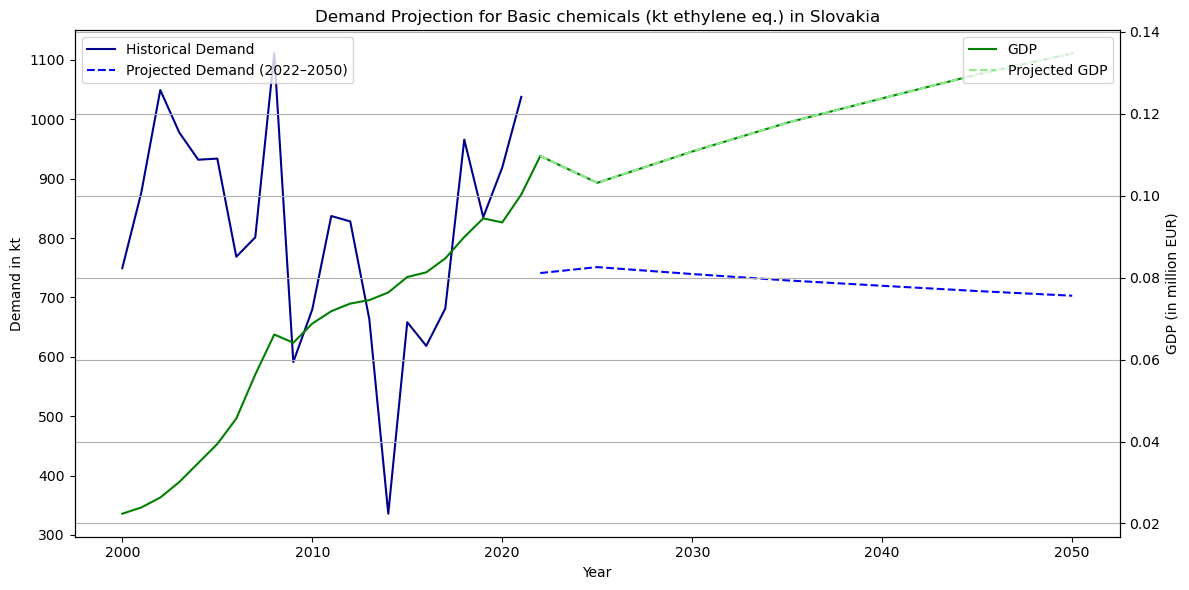

In [78]:
# Run linear regression for the basic chemicals sector to project demand until 2050
basic_chem_projection = linear_regression_single_sector(
    demand_df=basic_chem,                      # DataFrame with historical demand (kt)
    sector_name=basic_chem.columns[0],         # Use the first column name as the sector label
    historic_gdp=historic_gdp,                 # GDP data for training the model
    projected_gdp=projected_gdp,               # Future GDP data for prediction
    gdp=gdp,                                    # Full GDP data for plotting
    region=gdp_region,                         # GDP region name
    unit="kt",                                  # Unit of demand
    plot=True,                                  # Show plot with projections
    save=False                                  # Do not save to file (set to True if needed)
)


#### Detailed Step 3/4/5: Calculating Product Shares in Basic Chemical Demand

3. **Determine the shares of methanol, ammonia, and HVC** in overall basic chemical demand by using calibrated, plant-level production data from **Neuwirth et al. (2024)**. 

This allows for a more representative allocation of total chemical demand across product categories.

---

#### JRC Data on the Chemical Sector

![JRC Chemicals](JRC_Chemicals.png)

The **JRC (2022)** dataset provides a comprehensive projection of total chemical demand in Europe, expressed in **kt ethylene equivalent**. 

However, it includes a wide array of chemical products beyond the hydrogen-relevant ones considered here.

---

#### Comparison: Neuwirth (2024) vs. JRC (2022)

- **Neuwirth (2024)** estimates production of approximately **34,145 kt ethylene equivalent** for Europe (based on ammonia, methanol, and ethylene).

- **JRC (2022)** reports a broader estimate of **86,747 kt ethylene equivalent**, which includes additional chemical categories beyond the hydrogen-intensive ones.

Because of this discrepancy, a **scaling factor** is applied to align Neuwirth's hydrogen-relevant chemical coverage with the broader JRC projection. 

This factor represents the share of hydrogen-relevant chemicals in the current baseline (2021).

---

#### Converting Product Shares to Final Demand Estimates

Once this percentage share is derived, it is applied to the **JRC forward projections** (2022–2050) to isolate the demand evolution for hydrogen-relevant chemicals only. 

The shares for **methanol, ammonia, and HVC** are then used to split the JRC aggregate demand accordingly.

Finally, demand values expressed in **ethylene-equivalent kilotonnes (kt)** are converted into **product-specific units** (e.g., kt methanol or kt ammonia), using the energy-based conversion factors from **Saygin et al. (2011)** and **Neuwirth (2022)**.



In [74]:
# -------------------------------------------------------------
# Load Industrial Production Data from Neuwirth (2024) Excel
# -------------------------------------------------------------
neuwirth_df = pd.read_excel(
    "Industry_Data/Neuwirth_2024_Supplementary_Data/02_Industrial_Site_Database.xlsx",
    sheet_name="Database"
)
if jrc_region !="EU27":
    neuwirth_df = neuwirth_df.loc[neuwirth_df.Country == jrc_region]
    
# -------------------------------------------------------------
# Filter for calibrated production by product
# -------------------------------------------------------------
df_steel_primary = neuwirth_df.query("Product == 'Steel, primary'")
df_ethylene = neuwirth_df.query("Product == 'Ethylene'")
df_methanol = neuwirth_df.query("Product == 'Methanol'")
df_ammonia = neuwirth_df.query("Product == 'Ammonia'")

# -------------------------------------------------------------
# Compute total calibrated production per product [in tonnes]
# -------------------------------------------------------------
steel_primary_tons = df_steel_primary["Production in tons (calibrated)"].sum()
ethylene_tons = df_ethylene["Production in tons (calibrated)"].sum()
methanol_tons = df_methanol["Production in tons (calibrated)"].sum()
ammonia_tons = df_ammonia["Production in tons (calibrated)"].sum()


In [ ]:
# -------------------------------------------------------------
# Convert methanol and ammonia production to ethylene-equivalent demand
# -------------------------------------------------------------

# Estimated demand for methanol and ammonia, expressed in ethylene-equivalent tonnes
methanol_demand_ethylene_eq_tons = methanol_tons * MeOH_to_HVC
ammonia_demand_ethylene_eq_tons  = ammonia_tons * NH3_to_HVC

# Total chemical demand in ethylene-equivalent terms [tonnes]
total_chemical_demand_ethylene_eq_tons = (
    ethylene_tons + methanol_demand_ethylene_eq_tons + ammonia_demand_ethylene_eq_tons
)

# Convert to kilotonnes [kt]
total_chemical_demand_ethylene_eq_kt = total_chemical_demand_ethylene_eq_tons / 1000

# -------------------------------------------------------------
# Calculate 2022 demand shares for methanol, ammonia, and ethylene
# -------------------------------------------------------------
baseline_2022_demand_kt = basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"].iloc[0]

share_methanol = (methanol_demand_ethylene_eq_tons / 1000) / baseline_2022_demand_kt
share_ammonia  = (ammonia_demand_ethylene_eq_tons / 1000)  / baseline_2022_demand_kt
share_ethylene = (ethylene_tons / 1000) / baseline_2022_demand_kt


####  Calculation Steps and Modeling Logic

4. **Apply those shares** to disaggregate the JRC projections into product-specific demand.


In [ ]:
# -------------------------------------------------------------
# Apply calculated shares to disaggregate projected chemical demand
# -------------------------------------------------------------
basic_chem_projection["Methanol Demand [kt ethylene eq]"] = basic_chem_projection["Predicted Demand"] * share_methanol
basic_chem_projection["Ammonia Demand [kt ethylene eq]"]  = basic_chem_projection["Predicted Demand"] * share_ammonia
basic_chem_projection["Ethylene Demand [kt ethylene eq]"] = basic_chem_projection["Predicted Demand"] * share_ethylene



####  Calculation Steps and Modeling Logic

5. **Convert demand units** from ethylene-equivalent to product-specific demand using energy-based conversion factors.


In [92]:

# -------------------------------------------------------------
# 🔁 Convert ethylene-equivalent demand to material-specific units
# -------------------------------------------------------------
basic_chem_projection["Methanol Demand [kt MeOH]"] = basic_chem_projection["Methanol Demand [kt ethylene eq]"] / MeOH_to_HVC
basic_chem_projection["Ammonia Demand [kt NH3]"]   = basic_chem_projection["Ammonia Demand [kt ethylene eq]"] / NH3_to_HVC

# Convert HVC demand to methanol-equivalent via SEC and conversion factor
basic_chem_projection["High Value Chemicals Demand [kt MeOH]"] = basic_chem_projection["Ethylene Demand [kt ethylene eq]"] * SEC_HVC_Average_GWh * HVC_to_MeOH

In [85]:
basic_chem_projection

,Predicted Demand,Methanol Demand [kt ethylene eq],Ammonia Demand [kt ethylene eq],Ethylene Demand [kt ethylene eq],Methanol Demand [kt MeOH],Ammonia Demand [kt NH3],High Value Chemicals Demand [kt MeOH]
Year,,,,,,,
2022-01-01,741.117236,0.0,355.569823,169.478000,0.0,355.000000,1.862398
2023-01-01,744.443460,0.0,357.165664,170.238638,0.0,356.593283,1.870757
2024-01-01,747.769684,0.0,358.761504,170.999276,0.0,358.186566,1.879116
2025-01-01,751.095908,0.0,360.357345,171.759914,0.0,359.779849,1.887474
2026-01-01,748.764223,0.0,359.238660,171.226706,0.0,358.662957,1.881615
2027-01-01,746.432538,0.0,358.119975,170.693498,0.0,357.546065,1.875756
2028-01-01,744.100853,0.0,357.001290,170.160291,0.0,356.429172,1.869896
2029-01-01,741.769168,0.0,355.882605,169.627083,0.0,355.312280,1.864037
2030-01-01,739.437483,0.0,354.763920,169.093876,0.0,354.195388,1.858177


### Validation by comparing Neuwirth and JRC data

In [86]:
# Get t_ethylene eq to compare
methanol_tons_ethylene_eq = methanol_tons*MeOH_to_HVC
ammonia_tons_ethylene_eq = ammonia_tons*NH3_to_HVC

In [87]:
# Sum of all basic chemical production
neuwirth_chems_sum = ethylene_tons + methanol_tons_ethylene_eq + ammonia_tons_ethylene_eq

# from t ethylene eq to kt ethylene eq
neuwirth_chems_sum/1000 

525.047823434992

In [91]:
basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"]

Year
2022-01-01    741.117236
Name: Predicted Demand, dtype: float64

#### Non Metallic Minerals - Cement, Ceramics and Glass production

In [36]:
NMM_column_name = jrc_region+ ': Non-metallic mineral products / final energy consumption'


In [37]:
def transpose_uniformly(df):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)
    df_T.index.name = 'Year'
    df_T.index= pd.to_datetime(df_T.index, format='%Y')
    return(df_T)

In [93]:
def linear_regression_share_prediction(demand_sector_df, future_data_df, column_name_LR, column_name_IV, column_name_IV_future,  graph_title, save=False):
    """
    Perform a simple linear regression on historical data, visualize results, and predict future values.
    
    Parameters:
    - demand_sector_df: DataFrame containing historical demand data.
    - future_data_df: DataFrame containing future values of the independent variable for prediction.
    - column_name_LR: Name of the column in demand_sector_df to be used as the target variable (y).
    - column_name_IV: Name of the column in demand_sector_df and future_data_df to be used as the independent variable (X).
    - save: Boolean indicating whether to save the results to an Excel file.
    
    Returns:
    - A DataFrame containing historical and future predictions.
    """

    # Define the target (y) and feature (X) for historical data
    y = demand_sector_df[column_name_LR]  # Convert y to a Series
    X = demand_sector_df[[column_name_IV]]  # Independent variable (e.g., GDP)

    # Drop NaN values to avoid regression errors
    X = X.dropna()
    y = y.loc[X.index]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict historical values
    y_pred = model.predict(X)

    # Combine predictions and actual values into a results DataFrame
    results_historical = pd.DataFrame({
        'Actual Percentage': y,
        'Predicted Percentage': y_pred
    }, index=X.index)

    # Prepare future data for prediction
    future_data_df = future_data_df.rename(columns={column_name_IV_future: column_name_IV})
    X_future = future_data_df[[column_name_IV]].dropna()  # Independent variable for future data
    y_future_pred = model.predict(X_future)

    # Combine future predictions into a results DataFrame
    results_future = pd.DataFrame({
        'Predicted Percentage': y_future_pred
    }, index=X_future.index)

    # Combine historical and future results
    combined_results = pd.concat([results_historical[['Predicted Percentage']], results_future], axis=0)

    # Plot historical actual vs. predicted values and future predictions
    plt.figure(figsize=(10, 6))
    plt.plot(results_historical.index, results_historical['Actual Percentage'], label='Actual Percentage (Historical)', color='blue')
    plt.plot(results_historical.index, results_historical['Predicted Percentage'], label='Predicted Percentage (Historical)', color='orange', linestyle='--')
    plt.plot(results_future.index, results_future['Predicted Percentage'], label='Predicted Percentage (Future)', color='green', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel(f'{column_name_LR}')
    plt.title(graph_title)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save results to Excel if requested
    if save:
        combined_results.to_excel(f"results_{column_name_LR}_demand_with_predictions.xlsx")
    
    return combined_results


In [95]:
ktoe_to_GWh = 11.63

In [96]:
NMM = pd.read_excel(file_name, sheet_name="NMM_fec")
NMM.columns = NMM.columns.astype(str)  # Ensure all column names are strings
NMM_cleaned = NMM.loc[:, ~NMM.columns.str.contains('^Unnamed:')]
NMM_cleaned.dropna(how='any', inplace = True)
NMM_cleaned.reset_index(drop=True, inplace=True)


C:\Users\flv.eco\AppData\Local\Temp\ipykernel_9648\3130932235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NMM_cleaned.dropna(how='any', inplace = True)


In [40]:
cement = NMM_cleaned.iloc[:(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])]
ceramics = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])]
glass = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass: Finishing processes"].index[0]+1)]

#### Cement

Green fuel demand only in preheating and clinker production. Currently, 67% using already alternative heating sources such as different forms of waste.  
The TRL of the alternative production routes is fairly low with levels of <3 for a full electrification, <4 for hydrogen heating systems. Alternative options are hybrid versions discussed, the TRL levels remain low.  
Workaround: 
1. Replacing fossil fuel in the process of clinker production and Preheating and pre calcination process which is specifically distingished in JRC data set
2. Assuming waste as input
3. Increase waste share according to regression analysis, remaining share is taken from hydrogen/electricity 

##### Cement Biomass Content
1. Clean Data read from excel file
2. Get relevant data from fuel demand 
3. Get Percentage for biomass content
4. Match with overall fuel consumption (Forecast)

In [42]:
historic_cement_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Cement"].index[0])]

c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


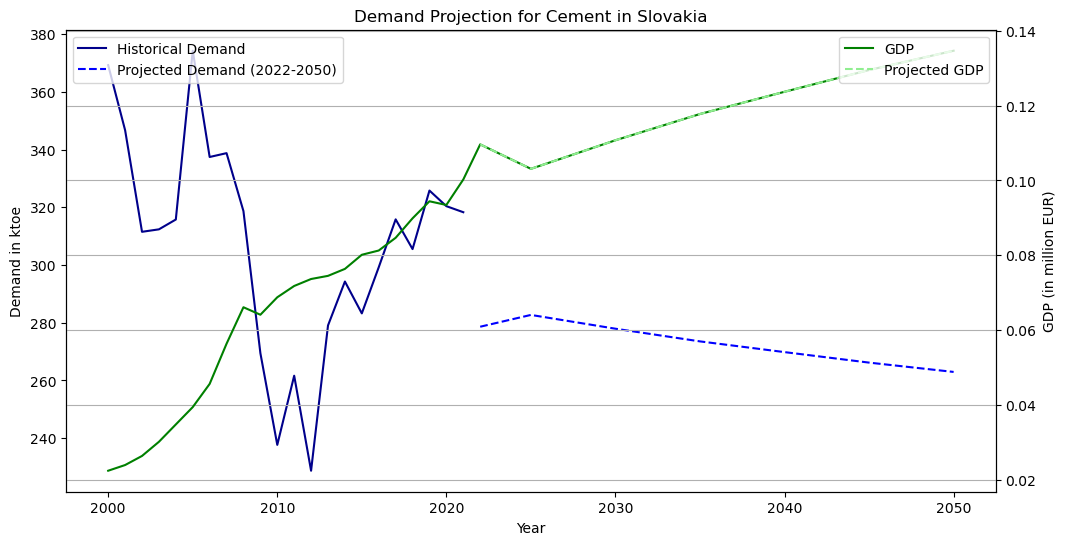

In [47]:
cement_projection = linear_regression_single_sector(demand_df=historic_cement_demand_ktoe, sector_name = historic_cement_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)

In [43]:
historic_cement_demand_ktoe = transpose_uniformly(historic_cement_demand_ktoe)
historic_cement_demand_ktoe = historic_cement_demand_ktoe.to_frame()
historic_cement_demand_ktoe.columns=["Cement"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [41]:
cement_preheating = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Pre-heating and pre-calcination"].index[0]):(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0])]
cement_clinker = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0]):(cement[cement[NMM_column_name] == "Cement: Grinding, packaging and precasting (electricity)"].index[0])]

In [44]:
cement_clinker = transpose_uniformly(cement_clinker)
cement_preheating = transpose_uniformly(cement_preheating)

In [45]:
cement_preheating

SK: Non-metallic mineral products / final energy consumption,Cement: Pre-heating and pre-calcination,Solids,LPG,Diesel oil and liquid biofuels,Fuel oil,Other liquids,Natural gas and biogas,Biomass and waste
Year,,,,,,,,
2000-01-01,134.361714,27.389667,0.0,0.782353,0.0,0.0,52.689898,53.499796
2001-01-01,126.319118,35.177086,0.0,0.773132,3.178089,11.263617,70.699097,5.228097
2002-01-01,109.509584,26.477886,0.0,0.52643,0.498311,10.326367,69.596823,2.083767
2003-01-01,106.287506,34.438294,0.0,1.115885,6.333273,7.713958,56.456382,0.229714
2004-01-01,108.097912,37.195275,0.0,5.148521,0.0,15.296368,50.283416,0.174332
2005-01-01,132.033622,39.047019,0.0,0.624173,7.091987,12.049264,72.041527,1.179652
2006-01-01,118.418177,36.332085,0.0,0.305323,13.596173,10.593864,56.922092,0.66864
2007-01-01,117.427528,37.600277,0.0,0.579094,13.151061,3.575522,62.141847,0.379727
2008-01-01,110.796081,45.881111,0.0,0.58955,13.16636,4.415869,46.377517,0.365673


In [ ]:
historic_cement_demand_ktoe["Biomass and waste fuel share"] = (cement_clinker["Biomass and waste"]+cement_preheating["Biomass and waste"])/historic_cement_demand_ktoe["Cement"]

historic_cement_demand_ktoe["Remainder fuel share"] = ((cement_clinker["Cement: Clinker production (kilns)"]-cement_clinker["Biomass and waste"])+(cement_preheating["Cement: Pre-heating and pre-calcination"]-cement_preheating["Biomass and waste"]))/historic_cement_demand_ktoe["Cement"]



In [ ]:

cement_projection.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
cement_projection["Predicted Demand [GWh]"] = cement_projection["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [49]:
historic_cement_demand_ktoe = historic_cement_demand_ktoe.fillna(0)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2822428962.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  historic_cement_demand_ktoe = historic_cement_demand_ktoe.fillna(0)


In [94]:
historic_cement_demand_ktoe

NameError: name 'historic_cement_demand_ktoe' is not defined

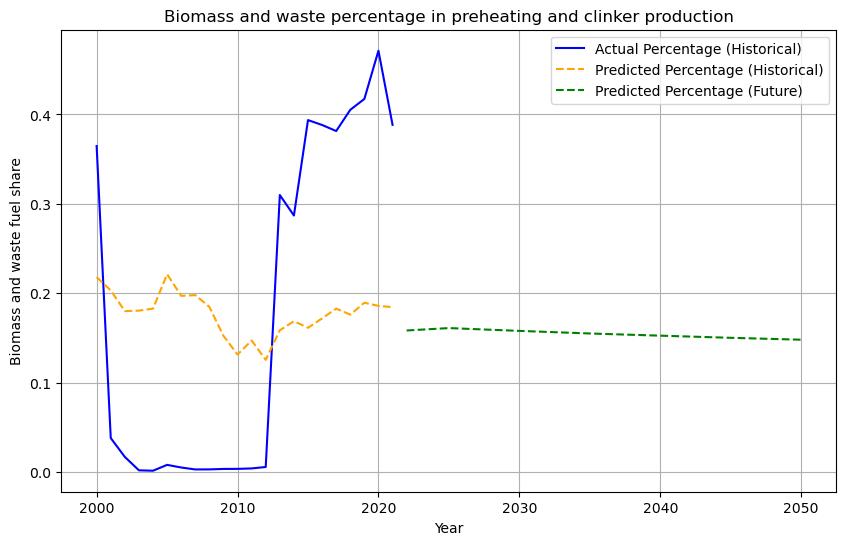

In [ ]:
cement_projection_biomass_percentage= linear_regression_share_prediction(demand_sector_df=historic_cement_demand_ktoe,future_data_df=cement_projection, column_name_LR="Biomass and waste fuel share", column_name_IV="Cement",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Biomass and waste percentage in preheating and clinker production", save = False)


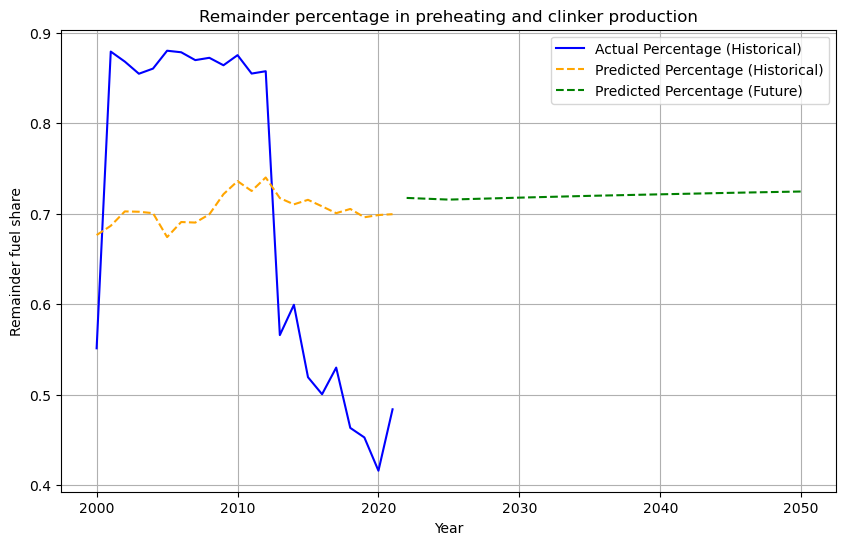

In [ ]:
cement_projection_NG_H2_percentage = linear_regression_share_prediction(demand_sector_df=historic_cement_demand_ktoe,future_data_df=cement_projection, column_name_LR="Remainder fuel share", column_name_IV="Cement",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Remainder percentage in preheating and clinker production", save = False)

In [52]:
cement_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
cement_projection_NG_H2_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/H2 Percentage'}, inplace=True)


In [53]:
cement_projection["Predicted Biomass Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_biomass_percentage["Predicted Biomass Percentage"]
cement_projection["Predicted Remainder Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_NG_H2_percentage["Predicted NG/H2 Percentage"]


In [54]:
targets_cement = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}
cement_projection = apply_linear_target(cement_projection, "Predicted Remainder Demand [GWh]","Green Fuel demand in GWh", targets_cement)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\538872229.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)


In [55]:
cement_projection

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted Biomass Demand [GWh],Predicted Remainder Demand [GWh],Green Fuel demand in GWh
Year,,,,,
2022-01-01,278.607555,3240.205865,512.815269,2324.108591,0.000000
2023-01-01,279.970897,3256.061537,518.247962,2333.471760,0.000000
2024-01-01,281.334240,3271.917208,523.709125,2342.815357,0.000000
2025-01-01,282.697582,3287.772880,529.198758,2352.139381,0.000000
2026-01-01,281.741878,3276.658046,525.347538,2345.605286,0.000000
2027-01-01,280.786175,3265.543211,521.510309,2339.061573,0.000000
2028-01-01,279.830471,3254.428376,517.687070,2332.508242,0.000000
2029-01-01,278.874767,3243.313542,513.877822,2325.945293,0.000000
2030-01-01,277.919063,3232.198707,510.082563,2319.372727,231.937273


In [56]:
cement_projection_biomass_percentage["Predicted Biomass Percentage"]+cement_projection_NG_H2_percentage["Predicted NG/H2 Percentage"]

Year
2000-01-01    0.894191
2001-01-01    0.889551
2002-01-01    0.882307
2003-01-01    0.882483
2004-01-01    0.883183
2005-01-01    0.895221
2006-01-01    0.887642
2007-01-01    0.887917
2008-01-01    0.883783
2009-01-01    0.873651
2010-01-01    0.867112
2011-01-01    0.872046
2012-01-01    0.865270
2013-01-01    0.875632
2014-01-01    0.878761
2015-01-01    0.876489
2016-01-01    0.879774
2017-01-01    0.883195
2018-01-01    0.881075
2019-01-01    0.885249
2020-01-01    0.884137
2021-01-01    0.883704
2022-01-01    0.875538
2023-01-01    0.875819
2024-01-01    0.876099
2025-01-01    0.876380
2026-01-01    0.876183
2027-01-01    0.875987
2028-01-01    0.875790
2029-01-01    0.875593
2030-01-01    0.875396
2031-01-01    0.875216
2032-01-01    0.875035
2033-01-01    0.874854
2034-01-01    0.874673
2035-01-01    0.874493
2036-01-01    0.874340
2037-01-01    0.874187
2038-01-01    0.874034
2039-01-01    0.873881
2040-01-01    0.873728
2041-01-01    0.873578
2042-01-01    0.873428
2043-0

#### Ceramics
Switch from NG to electrical heating requires new oven design and high investment cost, TRL<4
Switch from NG to hydrogen technically possible within the existing plant design. However, no industrial application so far, TRL <5

Workaround: 
1. Substituting fossil fuels  in the process
2. Assuming SNG/Hydrogen as a replacement

In the process of thermal drying and sintering, and in the production - majority is provided by SNG/H2/etc.   
In the primary production the biomass share is increase according to linear regression. 


In [57]:
historic_ceramics_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])]

In [58]:
historic_ceramics_demand_ktoe = transpose_uniformly(historic_ceramics_demand_ktoe)
historic_ceramics_demand_ktoe = historic_ceramics_demand_ktoe.to_frame()
historic_ceramics_demand_ktoe.columns=["Ceramics"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [59]:
ceramics_sintering = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal drying and sintering"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Microwave drying and sintering"].index[0]-1)]
ceramics_production = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal kiln"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Electric kiln"].index[0])]

In [60]:
ceramics_sintering = transpose_uniformly(ceramics_sintering)
ceramics_production = transpose_uniformly(ceramics_production)

In [61]:
ceramics_sintering["Ceramics: Drying and sintering of raw material"] = ceramics_sintering["Ceramics: Thermal drying and sintering"]+ceramics_sintering["Ceramics: Steam drying and sintering"]
ceramics_production["Ceramics: Primary production process"] = ceramics_production["Ceramics: Thermal kiln"]+ceramics_production["Ceramics: Electric kiln"]

In [62]:
ceramics_production

SK: Non-metallic mineral products / final energy consumption,Ceramics: Thermal kiln,Solids,LPG,Diesel oil and liquid biofuels,Fuel oil,Other liquids,Natural gas and biogas,Biomass and waste,Ceramics: Electric kiln,Ceramics: Primary production process
Year,,,,,,,,,,
2000-01-01,171.013278,34.861097,0.0,0.995766,0.0,0.0,67.062795,68.09362,10.008132,181.02141
2001-01-01,88.684929,24.696795,0.0,0.542793,2.231243,7.907853,49.635752,3.670493,4.834891,93.51982
2002-01-01,76.775457,18.563232,0.0,0.369072,0.349358,7.239655,48.793244,1.460896,6.346631,83.122088
2003-01-01,62.738684,20.328008,0.0,0.658677,3.738362,4.553344,33.324698,0.135594,6.951103,69.689786
2004-01-01,23.471926,8.076426,0.0,1.117928,0.0,3.321389,10.91833,0.037854,2.463432,25.935358
2005-01-01,40.173593,11.880755,0.0,0.189916,2.157864,3.666204,21.919924,0.35893,3.318107,43.491701
2006-01-01,38.840015,11.916572,0.0,0.100143,4.459413,3.474685,18.669895,0.219308,3.363924,42.203939
2007-01-01,57.034446,18.262421,0.0,0.281265,6.387459,1.736628,30.18224,0.184433,5.55141,62.585856
2008-01-01,52.385491,21.693047,0.0,0.278745,6.225186,2.087867,21.927752,0.172894,4.936085,57.321576


In [63]:
historic_ceramics_demand_ktoe["Share of Sintering"] = ceramics_sintering["Ceramics: Steam drying and sintering"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Share of NG/Biogas in primary production of total"] = ceramics_production["Natural gas and biogas"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Share of Biomass in primary production of total"] =  ceramics_production["Biomass and waste"]/historic_ceramics_demand_ktoe["Ceramics"]
historic_ceramics_demand_ktoe["Remainder share in primary thermal production of total"] = (ceramics_production["Ceramics: Thermal kiln"] - ceramics_production["Natural gas and biogas"] - ceramics_production["Biomass and waste"])/historic_ceramics_demand_ktoe["Ceramics"]


In [64]:
historic_ceramics_demand_ktoe

,Ceramics,Share of Sintering,Share of NG/Biogas in primary production of total,Share of Biomass in primary production of total,Remainder share in primary thermal production of total
Year,,,,,
2000-01-01,271.002763,0.02594,0.247462,0.251265,0.132312
2001-01-01,143.899005,0.047792,0.344935,0.025507,0.245858
2002-01-01,134.297719,0.060951,0.363321,0.010878,0.197482
2003-01-01,116.117819,0.05921,0.28699,0.001168,0.252144
2004-01-01,43.100416,0.063509,0.253323,0.000878,0.290386
2005-01-01,68.692519,0.039409,0.319102,0.005225,0.260505
2006-01-01,67.20139,0.042616,0.27782,0.003263,0.296881
2007-01-01,100.833105,0.041293,0.299329,0.001829,0.264474
2008-01-01,92.378756,0.044824,0.237368,0.001872,0.327833


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


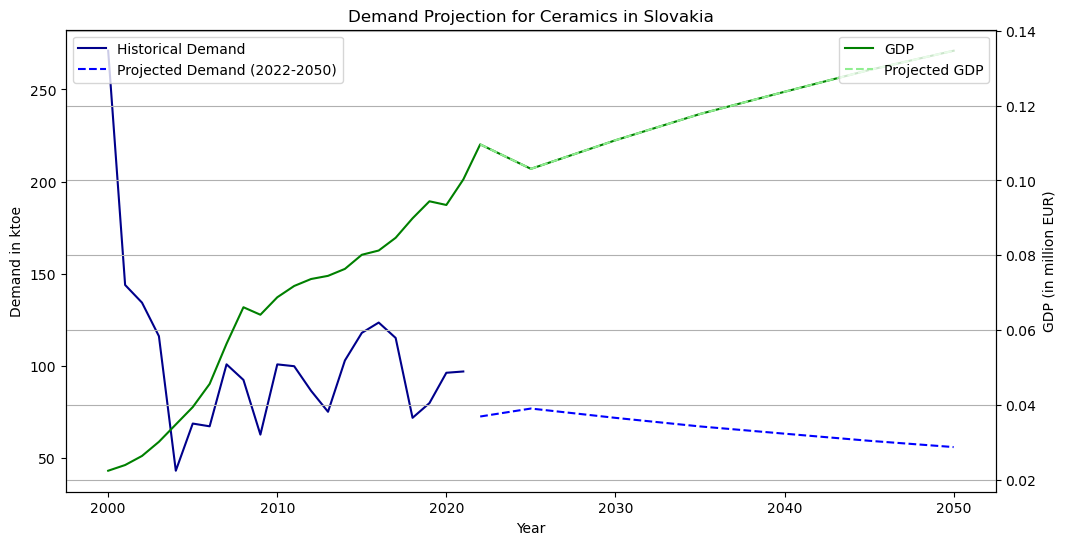

In [65]:
ceramics_prediction = linear_regression_single_sector(demand_df=historic_ceramics_demand_ktoe, sector_name = historic_ceramics_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)

In [66]:

ktoe_to_GWh = 11.63

ceramics_prediction.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
ceramics_prediction["Predicted Demand [GWh]"] = ceramics_prediction["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [67]:
ceramics_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh]
Year,,
2022-01-01,72.513338,843.330122
2023-01-01,73.956514,860.114255
2024-01-01,75.399689,876.898388
2025-01-01,76.842865,893.682522
2026-01-01,75.831198,881.916835
2027-01-01,74.819531,870.151148
2028-01-01,73.807864,858.385462
2029-01-01,72.796197,846.619775
2030-01-01,71.784530,834.854088


In [68]:
historic_ceramics_demand_ktoe = historic_ceramics_demand_ktoe.fillna(0)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2684171716.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  historic_ceramics_demand_ktoe = historic_ceramics_demand_ktoe.fillna(0)


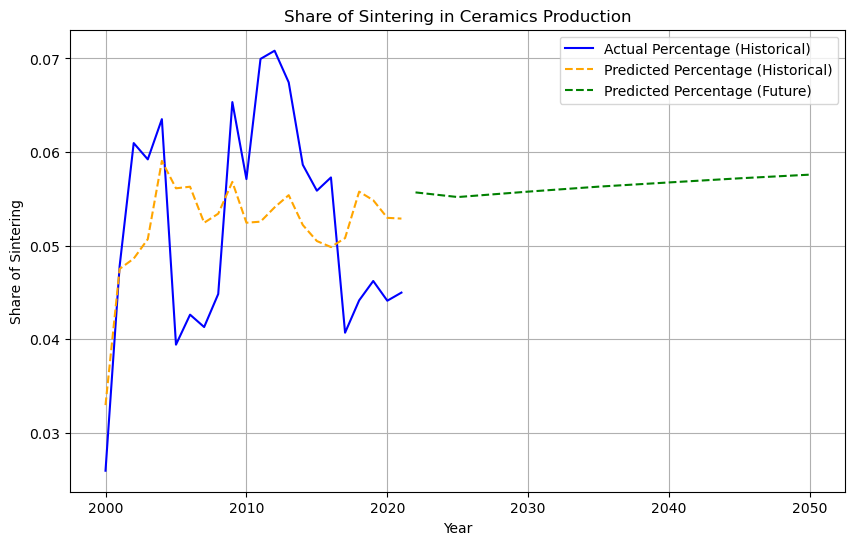

In [ ]:
ceramics_projection_sintering_percentage = linear_regression_share_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of Sintering", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Share of Sintering in Ceramics Production", save = False)

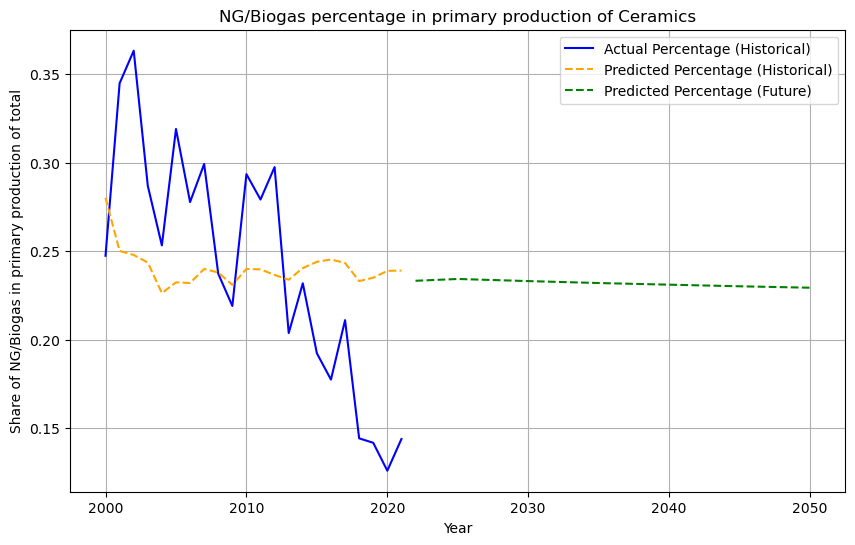

In [ ]:
ceramics_projection_NG_biogas_percentage = linear_regression_share_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of NG/Biogas in primary production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "NG/Biogas percentage in primary production of Ceramics", save = False)

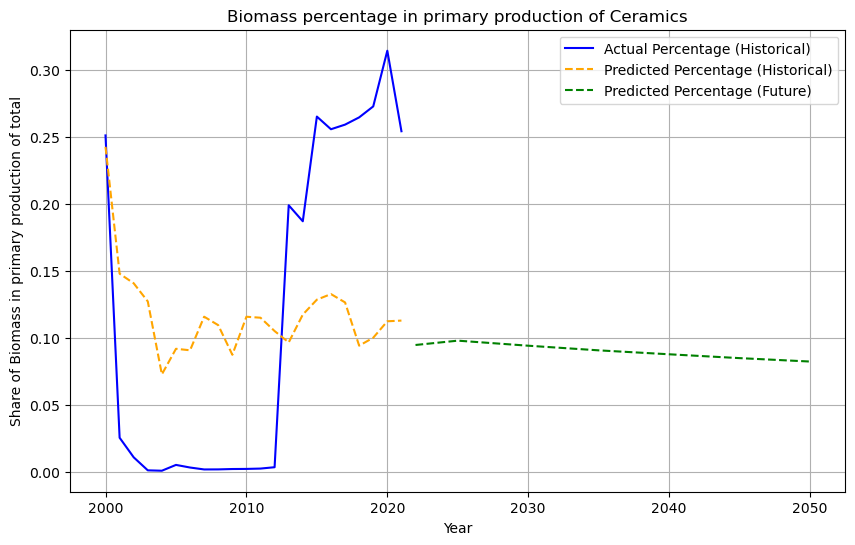

In [ ]:
ceramics_projection_biomass_percentage = linear_regression_share_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Share of Biomass in primary production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]", graph_title = "Biomass percentage in primary production of Ceramics",  save = False)

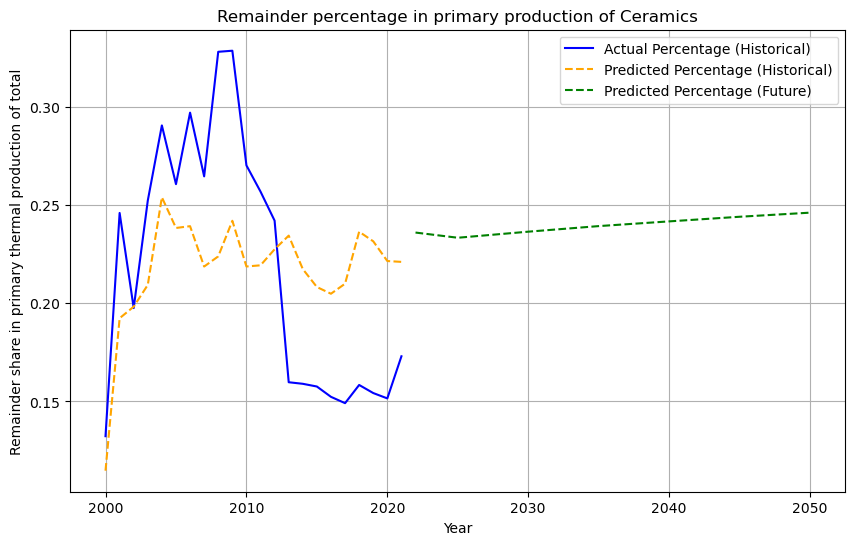

In [ ]:
ceramics_projection_remainder_percentage = linear_regression_share_prediction(demand_sector_df=historic_ceramics_demand_ktoe,future_data_df=ceramics_prediction, column_name_LR="Remainder share in primary thermal production of total", column_name_IV="Ceramics",column_name_IV_future= "Predicted Demand [ktoe]",graph_title = "Remainder percentage in primary production of Ceramics", save = False)

In [73]:
ceramics_projection_sintering_percentage.rename(columns={'Predicted Percentage': 'Predicted Sintering Percentage'}, inplace=True)
ceramics_projection_NG_biogas_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/H2 Percentage'}, inplace=True)
ceramics_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
ceramics_projection_remainder_percentage.rename(columns={'Predicted Percentage': 'Predicted Remainder Percentage'}, inplace=True)


In [74]:
ceramics_projection_sintering_percentage["Predicted Sintering Percentage"]+ceramics_projection_NG_biogas_percentage["Predicted NG/H2 Percentage"]+ceramics_projection_biomass_percentage["Predicted Biomass Percentage"]+ceramics_projection_remainder_percentage["Predicted Remainder Percentage"]

Year
2000-01-01    0.670661
2001-01-01    0.638011
2002-01-01    0.635545
2003-01-01    0.630875
2004-01-01    0.612119
2005-01-01    0.618693
2006-01-01    0.618310
2007-01-01    0.626949
2008-01-01    0.624777
2009-01-01    0.617152
2010-01-01    0.626941
2011-01-01    0.626687
2012-01-01    0.623260
2013-01-01    0.620334
2014-01-01    0.627487
2015-01-01    0.631334
2016-01-01    0.632771
2017-01-01    0.630626
2018-01-01    0.619493
2019-01-01    0.621545
2020-01-01    0.625771
2021-01-01    0.625951
2022-01-01    0.619674
2023-01-01    0.620045
2024-01-01    0.620415
2025-01-01    0.620786
2026-01-01    0.620526
2027-01-01    0.620266
2028-01-01    0.620007
2029-01-01    0.619747
2030-01-01    0.619487
2031-01-01    0.619248
2032-01-01    0.619009
2033-01-01    0.618770
2034-01-01    0.618531
2035-01-01    0.618293
2036-01-01    0.618091
2037-01-01    0.617889
2038-01-01    0.617687
2039-01-01    0.617484
2040-01-01    0.617282
2041-01-01    0.617084
2042-01-01    0.616886
2043-0

In [75]:
ceramics_prediction["Predicted Sintering Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_sintering_percentage["Predicted Sintering Percentage"]
ceramics_prediction["Predicted NG/H2 Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_NG_biogas_percentage["Predicted NG/H2 Percentage"]
ceramics_prediction["Predicted Biomass Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_biomass_percentage["Predicted Biomass Percentage"]
ceramics_prediction["Predicted Remainder Demand [GWh]"] = ceramics_prediction["Predicted Demand [GWh]"]*ceramics_projection_remainder_percentage["Predicted Remainder Percentage"]

In [76]:
targets_ceramics = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}
ceramics_prediction = apply_linear_target(ceramics_prediction, "Predicted NG/H2 Demand [GWh]","H2/SNG demand in GWh", targets_ceramics)
ceramics_prediction = apply_linear_target(ceramics_prediction, "Predicted Remainder Demand [GWh]","Green Fuel demand in GWh", targets_ceramics)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\538872229.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)
C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\538872229.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)


In [77]:
ceramics_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted Sintering Demand [GWh],Predicted NG/H2 Demand [GWh],Predicted Biomass Demand [GWh],Predicted Remainder Demand [GWh],H2/SNG demand in GWh,Green Fuel demand in GWh
Year,,,,,,,,
2022-01-01,72.513338,843.330122,46.956369,196.777079,79.923208,198.933128,0.000000,0.000000
2023-01-01,73.956514,860.114255,47.748767,200.986505,82.439338,202.134723,0.000000,0.000000
2024-01-01,75.399689,876.898388,48.535618,205.207371,84.991588,205.306752,0.000000,0.000000
2025-01-01,76.842865,893.682522,49.316921,209.439677,87.579957,208.449212,0.000000,0.000000
2026-01-01,75.831198,881.916835,48.769809,206.471629,85.761723,206.249444,0.000000,0.000000
2027-01-01,74.819531,870.151148,48.219970,203.509203,83.961239,204.035147,0.000000,0.000000
2028-01-01,73.807864,858.385462,47.667405,200.552399,82.178504,201.806320,0.000000,0.000000
2029-01-01,72.796197,846.619775,47.112114,197.601216,80.413518,199.562963,0.000000,0.000000
2030-01-01,71.784530,834.854088,46.554098,194.655655,78.666281,197.305077,19.465565,19.730508


#### Glas
Difference between two processes: 
1. Containerglas in U shaped flame tray  
Percentage in energy consumption in Germany: 33-34%  
Electrification for small plant have a TRL 9, bigger plants <4  
Hydrogen fired burner, TRL <4
2. Continouus melting flat glass 
Percentage in energy consumption in Germany: 42-45%  
Electrification  <3  
Hydrogen fired burner, TRL <4

Workaround, assume that 44% of the demand in the melting process cannot be electriefied and therefore demand hydrogen after year 2040

In [78]:
historic_glass_demand_ktoe = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])]
historic_glass_demand_ktoe = transpose_uniformly(historic_glass_demand_ktoe)
historic_glass_demand_ktoe = historic_glass_demand_ktoe.to_frame()
historic_glass_demand_ktoe.columns=["Glass"]

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2364290554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)


In [79]:
glass_thermal_melting = glass.loc[(glass[glass[NMM_column_name] == "Glass: Thermal melting tank"].index[0]):(glass[glass[NMM_column_name] == "Glass: Electric melting tank"].index[0]-1)]


In [80]:
glass_thermal_melting = transpose_uniformly(glass_thermal_melting)

In [81]:
historic_glass_demand_ktoe["Share of Thermal melting"] = glass_thermal_melting["Glass: Thermal melting tank"]/historic_glass_demand_ktoe["Glass"]


In [82]:
historic_glass_demand_ktoe

,Glass,Share of Thermal melting
Year,,
2000-01-01,76.00138,0.680523
2001-01-01,65.54229,0.698255
2002-01-01,55.404184,0.628546
2003-01-01,52.885285,0.571773
2004-01-01,51.298539,0.581974
2005-01-01,56.255947,0.629224
2006-01-01,57.755478,0.620264
2007-01-01,59.50553,0.59858
2008-01-01,46.958341,0.604803


c:\Users\flv.eco\AppData\Local\anaconda3\envs\ptx_markets\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


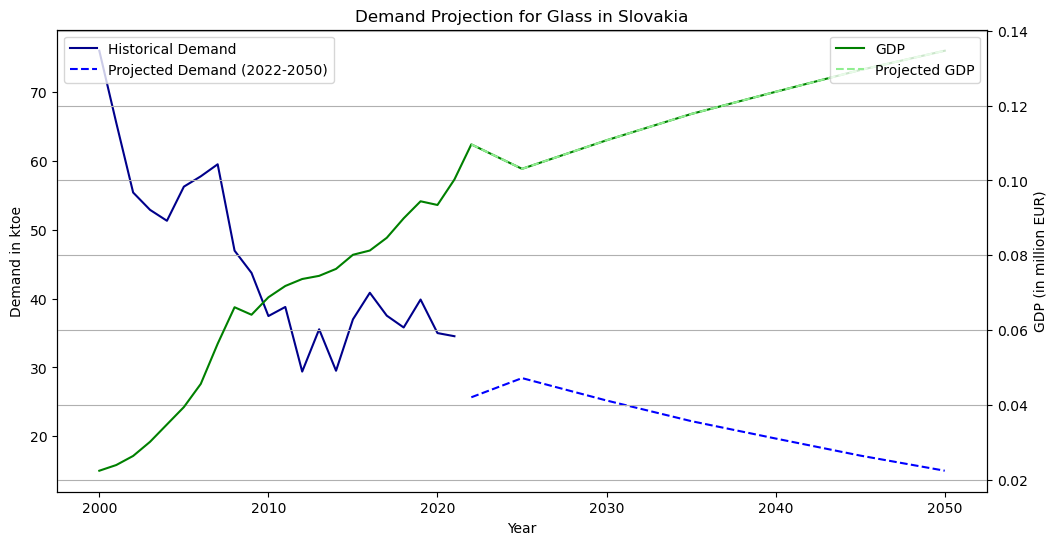

In [83]:
glass_prediction = linear_regression_single_sector(demand_df=historic_glass_demand_ktoe, sector_name = historic_glass_demand_ktoe.columns[0], historic_gdp=historic_gdp, projected_gdp=projected_gdp, gdp = gdp, region=gdp_region,unit = "ktoe", plot = True, save = False)
ktoe_to_GWh = 11.63

glass_prediction.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
glass_prediction["Predicted Demand [GWh]"] = glass_prediction["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [84]:
historic_glass_demand_ktoe = historic_glass_demand_ktoe.fillna(0)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\2124890673.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  historic_glass_demand_ktoe = historic_glass_demand_ktoe.fillna(0)


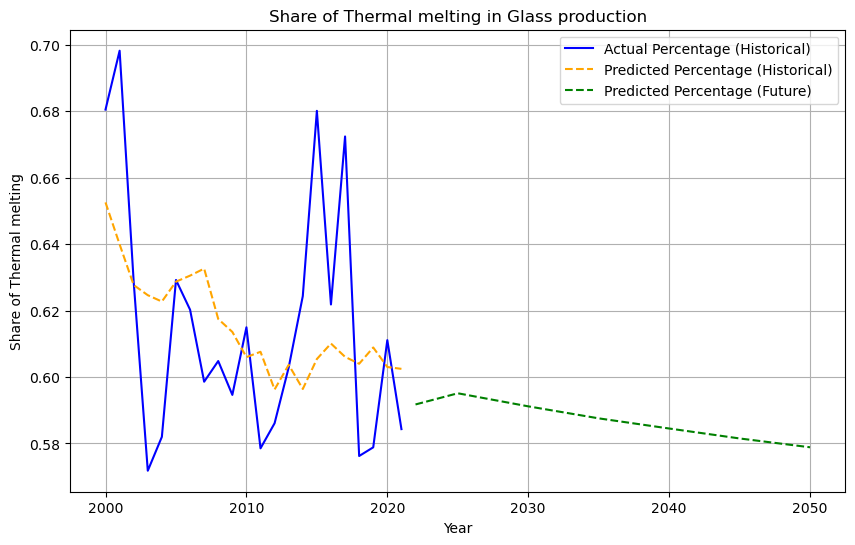

In [ ]:
glass_projection_thermal_melting_percentage = linear_regression_share_prediction(demand_sector_df=historic_glass_demand_ktoe,future_data_df=glass_prediction, column_name_LR="Share of Thermal melting", column_name_IV="Glass",column_name_IV_future= "Predicted Demand [ktoe]",graph_title = "Share of Thermal melting in Glass production", save = False)

In [86]:
glass_projection_thermal_melting_percentage.rename(columns={'Predicted Percentage': 'Predicted Thermal Melting Percentage'}, inplace=True)


In [87]:
glass_prediction["Predicted NG/H2 Demand [GWh]"] = glass_prediction["Predicted Demand [GWh]"]*glass_projection_thermal_melting_percentage["Predicted Thermal Melting Percentage"]


In [88]:
targets_glass = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}
glass_prediction = apply_linear_target(glass_prediction, "Predicted NG/H2 Demand [GWh]" , "H2/SNG demand in GWh", targets_glass)

C:\Users\flv.eco\AppData\Local\Temp\ipykernel_25332\538872229.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_share = target_years.reindex(full_index).interpolate(method='time').fillna(method='ffill').fillna(0)


In [89]:
glass_prediction

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted NG/H2 Demand [GWh],H2/SNG demand in GWh
Year,,,,
2022-01-01,25.658806,298.411913,176.578651,0.000000
2023-01-01,26.587461,309.212171,183.316540,0.000000
2024-01-01,27.516116,320.012429,190.078674,0.000000
2025-01-01,28.444771,330.812687,196.865053,0.000000
2026-01-01,27.793783,323.241700,192.105257,0.000000
2027-01-01,27.142796,315.670713,187.357374,0.000000
2028-01-01,26.491808,308.099726,182.621406,0.000000
2029-01-01,25.840820,300.528739,177.897352,0.000000
2030-01-01,25.189833,292.957753,173.185213,17.318521


#### Summary into relevant excel sheet

steel_bf_projection["Demand in tH2"]
basic_chem_projection["MeOH Demand [kt MeOH]","NH3 Demand [kt NH3]", "HVC Demand [kt MeOH]"]
cement_projection["Predicted Biomass Demand [GWh]", "Green Fuel demand in GWh"]
ceramics_prediction["H2/SNG demand in GWh","Predicted Biomass Demand [GWh]", "Green Fuel demand in GWh"]
glass_prediction["H2/SNG demand in GWh"]

conversion factor: 
tH2 = 0.0333 GWh
ktMeOH = 5.53 GWh
ktNH3 = 5.17 GWh


In [90]:
demand_2030 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass","Other"] )
demand_2040 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass", "Other"])
demand_2050 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass", "Other"])


In [91]:
conversion_tH2_GWh = 0.033
conversion_ktMeOH_GWh = 5.53
conversion_ktNH3_GWh = 5.17


In [ ]:
def prep_saving(df, year): 
    date = datetime.datetime(year=year, month=1, day=1)
    date_str = date.strftime("%Y-%m-%d")

    df.loc["Hydrogen", "Iron & steel"] = steel_bf_projection.loc[date_str,"Phased H2 Demand [t]"]*conversion_tH2_GWh
    df.loc["Ammonia","Chemicals"] = basic_chem_projection.loc[date_str,"NH3 Demand [kt NH3]"]*conversion_ktNH3_GWh
    df.loc["Methanol","Chemicals"]= (basic_chem_projection.loc[date_str,"MeOH Demand [kt MeOH]"]+basic_chem_projection.loc[date_str,"HVC Demand [kt MeOH]"])*conversion_ktMeOH_GWh
    df.loc["Hydrogen","Non-metallic minerals"] = ceramics_prediction.loc[date_str,"H2/SNG demand in GWh"]+glass_prediction.loc[date_str,"H2/SNG demand in GWh"]
    df.loc["Biomass", "Non-metallic minerals"] = cement_projection.loc[date_str,"Predicted Biomass Demand [GWh]"]+ceramics_prediction.loc[date_str,"Predicted Biomass Demand [GWh]"]
    df.loc["Other", "Non-metallic minerals"] = cement_projection.loc[date_str,"Green Fuel demand in GWh"]+ceramics_prediction.loc[date_str,"Green Fuel demand in GWh"]
    
    return df




In [93]:
demand_2030 = prep_saving(demand_2030, 2030)

In [94]:
demand_2040 = prep_saving(demand_2040, 2040)

In [95]:
demand_2050 = prep_saving(demand_2050, 2050)

In [96]:
demand_2030.to_excel("Scripts\GIT\PtX-Markets\Scripts\Industry\Results_per_Country\\2030_"+jrc_region+".xlsx")

In [97]:
demand_2040.to_excel("Scripts\GIT\PtX-Markets\Scripts\Industry\Results_per_Country\\2040_"+jrc_region+".xlsx")

In [98]:
demand_2050.to_excel("Scripts\GIT\PtX-Markets\Scripts\Industry\Results_per_Country\\2050_"+jrc_region+".xlsx")